In [35]:
import numpy as np
import pandas as pd
from skimage.io import imread,imsave, imshow
import matplotlib.pyplot as plt

In [36]:
from pathlib import Path

In [37]:
def rle_decode_s(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)

    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

In [38]:
def rle_decode(mask_rle, pre_msk,mask_class,shape=(256,1600)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    #img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    img = pre_msk
    
    for lo, hi in zip(starts, ends):
        #print("lo\t",lo,"hi\t",hi)
        if np.sum(img[lo:hi]) != 0:
            print("error: overlapping maks")
        #print("before \n",img[lo:hi])
        #print("mask class \t",mask_class)
        img[lo:hi] = mask_class
        #print("after \n",img[lo:hi])
    return img#.reshape(shape,order='F')

In [39]:
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    rles = []
    for c in [1,2,3,4]:
        msk = (img == c).astype(np.uint8)
        pixels = msk.flatten(order='F')
        pixels = np.concatenate([[0], pixels, [0]])
        runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
        runs[1::2] -= runs[::2]
        rle = ' '.join(str(x) for x in runs)
        rles.append(rle)
    return rles

In [40]:
import os

In [41]:
lbls_dir = Path('preds_full')

In [42]:
msk_fls = [f for f in lbls_dir.iterdir() if f.is_file()]

In [43]:
msk_fls[7]

PosixPath('preds_full/760aae1ec.png')

In [44]:
len(msk_fls)

1801

In [45]:
_ = imread('preds_full/28ae995da.png')

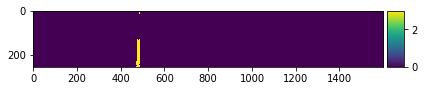

In [46]:
imshow(_)

In [47]:
np.unique(_)

Array([0, 3], dtype=uint8)

In [48]:
enc = rle_encode(_)

In [49]:
enc[1]

''

In [50]:
msk = np.zeros((256*1600),dtype=np.uint8)
for i in [0,1,2,3]:
    print(i)
    if enc[i] == '':
        print("esc")
        continue
    else:
        msk = rle_decode(enc[i],msk,i+1)

0
esc
1
esc
2
3
esc


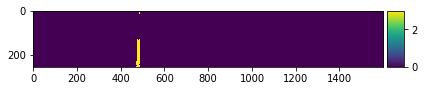

In [51]:
imshow(msk.reshape((256,1600),order='F'))

In [52]:
np.unique(msk)

array([0, 3], dtype=uint8)

## conervert masks to rle

In [55]:
df_msks_row = []
for fl in msk_fls:
    for i in [1,2,3,4]:
        df_msks_row.append(fl.stem+'.jpg_'+str(i))

In [56]:
len(df_msks_row)

7204

In [57]:
df_msks_row[:6]

['e9358bd1e.jpg_1',
 'e9358bd1e.jpg_2',
 'e9358bd1e.jpg_3',
 'e9358bd1e.jpg_4',
 '9cc10ade1.jpg_1',
 '9cc10ade1.jpg_2']

In [58]:
ss = pd.read_csv('sample_submission.csv',index_col='ImageId_ClassId')

In [59]:
ss.head(3)

,EncodedPixels
ImageId_ClassId,
004f40c73.jpg_1,1 1
004f40c73.jpg_2,1 1
004f40c73.jpg_3,1 1


In [60]:
sse = ss.copy(deep=True)

In [61]:
for a in ss.index[::4]:
    msk_nm = a[:-6]+'.png'
    msk = imread('preds_full/'+msk_nm)
    encs = rle_encode(msk)
    for i in [1,2,3,4]:
        if encs[i-1] == '':
            sse.loc[a[:-2]+"_"+str(i),'EncodedPixels'] = '1 0'
        else:
            sse.loc[a[:-2]+"_"+str(i),'EncodedPixels'] =  encs[i-1]

In [62]:
sse.head(3)

,EncodedPixels
ImageId_ClassId,
004f40c73.jpg_1,1 0
004f40c73.jpg_2,1 0
004f40c73.jpg_3,1 0


In [63]:
sse.EncodedPixels[7]

'1 0'

In [64]:
sse.head(5)

,EncodedPixels
ImageId_ClassId,
004f40c73.jpg_1,1 0
004f40c73.jpg_2,1 0
004f40c73.jpg_3,1 0
004f40c73.jpg_4,1 0
006f39c41.jpg_1,125632 1 125634 1 367586 1 367589 2 367836 13 ...


In [65]:
len(sse[sse.EncodedPixels=='1 0'])

5717

In [66]:
_1 = sse.iloc[0::4];
_2 = sse.iloc[1::4];
_3 = sse.iloc[2::4];
_4 = sse.iloc[3::4] 

In [67]:
len(_1[_1.EncodedPixels!='1 0']),len(_2[_2.EncodedPixels!='1 0']),len(_3[_3.EncodedPixels!='1 0']),len(_4[_4.EncodedPixels!='1 0'])

(353, 135, 847, 152)

In [68]:
sse.to_csv('sub1.csv')

In [69]:
ss = pd.read_csv('sub1.csv')

In [70]:
ss.sample(2)

,ImageId_ClassId,EncodedPixels
4137,9676c628e.jpg_2,1 0
315,0cca51b4a.jpg_4,1 0


In [71]:
ss.loc[ss.EncodedPixels == '1 0',ss.columns[1]] = '1 1'

In [72]:
samsu = pd.read_csv('sample_submission.csv')

In [73]:
samsu.head(2)

,ImageId_ClassId,EncodedPixels
0,004f40c73.jpg_1,1 1
1,004f40c73.jpg_2,1 1


In [14]:
a = np.random.randint(0,4,(4,3))

In [15]:
a

array([[0, 1, 2],
       [2, 2, 0],
       [0, 3, 0],
       [3, 3, 1]])

In [17]:
a.flatten(order='F')

array([0, 2, 0, 3, 1, 2, 3, 3, 2, 0, 0, 1])

In [39]:
sse.index[:7]

Index(['004f40c73.jpg_1', '004f40c73.jpg_2', '004f40c73.jpg_3',
       '004f40c73.jpg_4', '006f39c41.jpg_1', '006f39c41.jpg_2',
       '006f39c41.jpg_3'],
      dtype='object', name='ImageId_ClassId')

In [40]:
samp = pd.read_csv('sample_submission.csv',index_col='ImageId_ClassId')

In [41]:
samp.index[:7]

Index(['004f40c73.jpg_1', '004f40c73.jpg_2', '004f40c73.jpg_3',
       '004f40c73.jpg_4', '006f39c41.jpg_1', '006f39c41.jpg_2',
       '006f39c41.jpg_3'],
      dtype='object', name='ImageId_ClassId')

In [46]:
_ = sse.index.values == samp.index.values

In [47]:
_.sum()/len(_)

1.0